In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# from collections import namedtuple

In [ ]:
def model(x, a, b, c):
    return a * np.sin(b*x*np.pi + c)

In [ ]:
# import tensorflow as tf

In [ ]:
def lnlike(x, y, a, b, c, sigma):

    yhat = model(x, a, b, c)
    N = x.shape[0]

    term1 =  -0.5 * (N * np.log(2*np.pi*sigma**2)) 
    term2 =  -0.5/sigma**2 * np.sum((y - yhat)**2)

    # print(f"term1 = {term1}, term2 = {term2}")

    return term1 + term2

    # return tf.keras.losses.mse(y, yhat)

In [ ]:
a_true = 1
b_true = 1.5
c_true = 0.
sigma_true = 0.01

In [ ]:
x = np.linspace(0, 4, 200)

In [ ]:
y = model(x, a_true, b_true, c_true) + np.random.normal(0, sigma_true, size=x.shape)

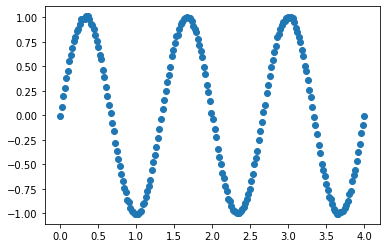

In [ ]:
plt.figure()
plt.plot(x, y, 'o')

In [ ]:
b_grid = np.linspace(b_true - 0.1, b_true + 0.1, 100)

In [ ]:
res = np.array([lnlike(x, y, a_true, b, c_true, sigma_true) for b in b_grid])

Text(0.5, 1.0, 'lnlike')

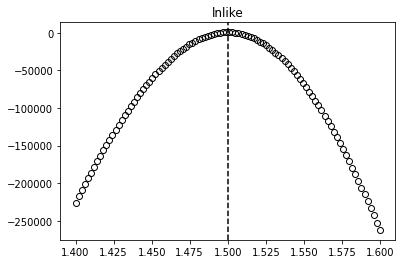

In [ ]:
plt.figure()
plt.plot(b_grid, res, 'ok', fillstyle='none')
plt.axvline(b_true, ls='--', c='k')
plt.title('lnlike')

Text(0.5, 1.0, 'exp(lnlike)')

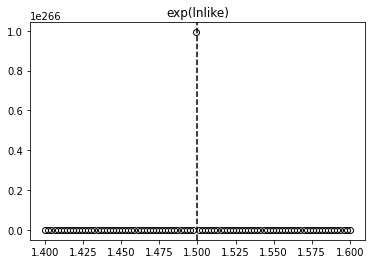

In [ ]:
plt.figure()
plt.plot(b_grid, np.exp(res), 'ok', fillstyle='none')
plt.axvline(b_true, ls='--', c='k')
plt.title('exp(lnlike)')

In [ ]:
np.argmax(res)

49

In [ ]:
np.max(res)

612.479996416189

In [ ]:
b_maxL = b_grid[np.argmax(res)]

In [ ]:
b_maxL

1.4989898989898989

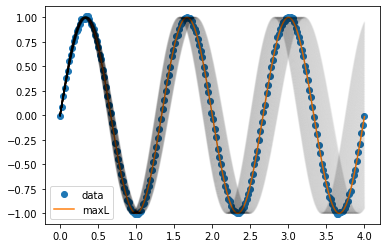

In [ ]:
plt.figure()
plt.plot(x, y, 'o', label='data')
plt.plot(x, model(x, a_true, b_maxL, c_true), label='maxL')
for b in b_grid:
    plt.plot(x, model(x, a_true, b, c_true), c='k', alpha=0.04)
plt.legend()

In [ ]:
# simple mcmc

np.random.seed(1)

nsteps = 100000

current_param = 1.2

current_lnlike = lnlike(x, y, a_true, current_param, c_true, sigma_true)

params = [current_param]
lnlikes = [current_lnlike]

for i in range(nsteps):
    if i % (nsteps/10) == 0:
        print(f"{i}", end=" ")


    new_param = current_param + np.random.normal(0, 0.1)
    # if i > 50000:
    #     new_param = current_param + np.random.normal(0, 0.01)
    new_lnlike = lnlike(x, y, a_true, new_param, c_true, sigma_true)

    lnalpha = np.log(np.random.uniform())

    # if greater then accept
    if new_lnlike > current_lnlike:
        current_lnlike = new_lnlike
        current_param = new_param
    #if smaller then accept with probability alpha
    else:
        # these two if's are the same
        if lnalpha < new_lnlike - current_lnlike:
        # if new_lnlike > current_lnlike + lnalpha:
            current_lnlike = new_lnlike
            current_param = new_param
    
    params.append(current_param)
    lnlikes.append(current_lnlike)

params = np.array(params)
lnlikes = np.array(lnlikes)

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 

In [ ]:
params[200:]

array([1.4997058 , 1.4997058 , 1.4997058 , ..., 1.49964964, 1.49964964,
       1.49964964])

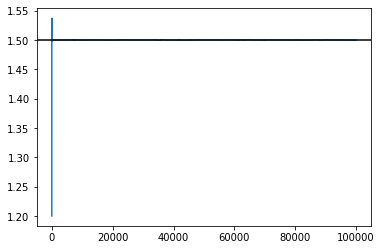

In [ ]:
plt.figure()
plt.plot(params)
plt.axhline(b_true, c='k')

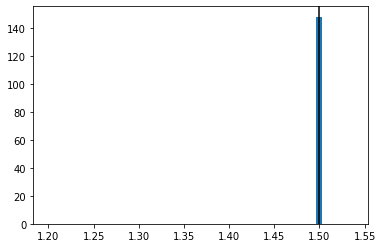

In [ ]:
plt.figure()
plt.hist(params, density=True, bins=50);
plt.axvline(b_true, c='k')

In [ ]:
burnin = 100

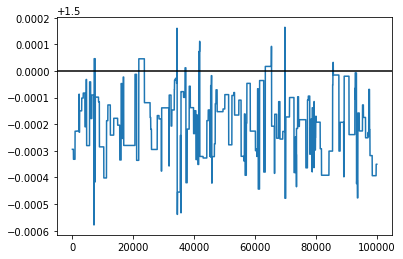

In [ ]:
plt.figure()
plt.plot(params[burnin:])
plt.axhline(b_true, c='k')

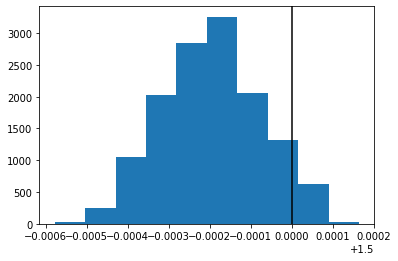

In [ ]:
plt.figure()
plt.hist(params[burnin:], density=True);
plt.axvline(b_true, c='k')

# multi dim mcmc

In [ ]:
a_true

1

In [ ]:
import scipy.stats as stats

In [ ]:
tmp = stats.truncnorm(1, 3)

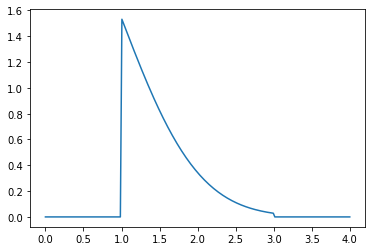

In [ ]:
plt.plot(x, tmp.pdf(x))

In [ ]:
# Evaluating the prior does seem to take a long time
def ln_prior(x):
    a, b, c, sigma = x
    sigma_prior = stats.truncnorm(1e-4, 100).pdf(sigma)
    a_prior = stats.norm(0, 2).pdf(a)
    b_prior = stats.norm(0, 2).pdf(b)
    c_prior = stats.norm(0, 2).pdf(c)

    return np.log(a_prior) + np.log(b_prior) + np.log(c_prior) + np.log(sigma)

In [ ]:
ln_prior([1,1.5, 0, 0.01])

-9.847677327281946

In [ ]:
def mcmc(x, y, lnlike_func, p0=[1, 1.5, 0, 0.01], nsteps=1000):
    current_param = np.array(p0)

    current_lnlike = lnlike(x, y,*current_param) + ln_prior(current_param)

    params = [current_param]
    lnlikes = [current_lnlike]

    for i in range(nsteps):
        if i % (nsteps/10) == 0:
            print(f"{i}", end=" ")


        new_param = current_param + np.random.normal(0, 0.001, size=4)
        # if i > 50000:
        #     new_param = current_param + np.random.normal(0, 0.01)
        new_lnlike = lnlike(x, y, *new_param) + ln_prior(current_param)

        lnalpha = np.log(np.random.uniform())

        # if greater then accept
        if new_lnlike > current_lnlike:
            current_lnlike = new_lnlike
            current_param = new_param
        #if smaller then accept with probability alpha
        else:
            # these two if's are the same
            if lnalpha < new_lnlike - current_lnlike:
            # if new_lnlike > current_lnlike + lnalpha:
                current_lnlike = new_lnlike
                current_param = new_param
        
        params.append(current_param)
        lnlikes.append(current_lnlike)

    params = np.array(params)
    lnlikes = np.array(lnlikes)

    return params, lnlikes

In [ ]:
%%time
chain, lnlikes = mcmc(x, y, lnlike, p0=[1.1, 1.5, 0, 0.01], nsteps=10000)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 CPU times: user 34.6 s, sys: 65.9 ms, total: 34.6 s
Wall time: 34.8 s


In [ ]:
chain

array([[ 1.10000000e+00,  1.50000000e+00,  0.00000000e+00,
         1.00000000e-02],
       [ 1.10014564e+00,  1.49998826e+00, -1.02495111e-04,
         1.01386412e-02],
       [ 1.10091576e+00,  1.50054733e+00, -1.72358845e-04,
         1.05226535e-02],
       ...,
       [ 1.00126552e+00,  1.50011955e+00, -1.99549434e-03,
         9.85424281e-03],
       [ 1.00126552e+00,  1.50011955e+00, -1.99549434e-03,
         9.85424281e-03],
       [ 1.00126552e+00,  1.50011955e+00, -1.99549434e-03,
         9.85424281e-03]])

In [ ]:
lnlikes

array([-4206.66821605, -4089.40446521, -3814.88433615, ...,
         621.84646653,   621.84646653,   621.84646653])

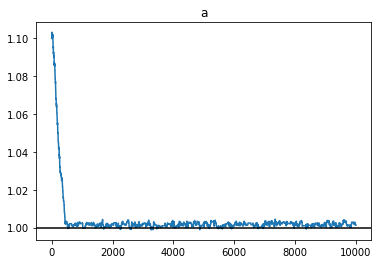

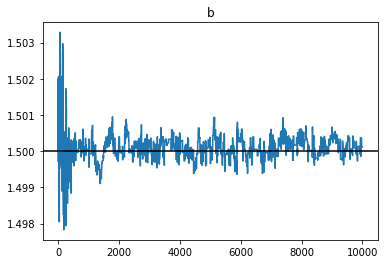

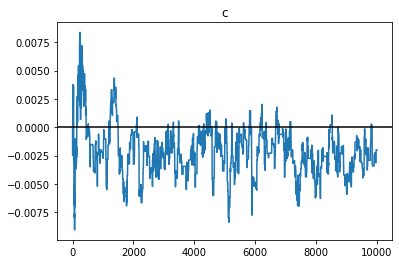

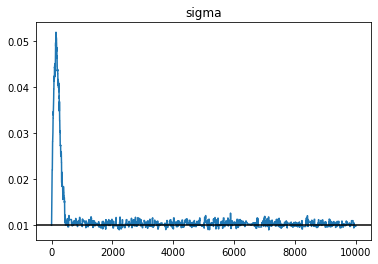

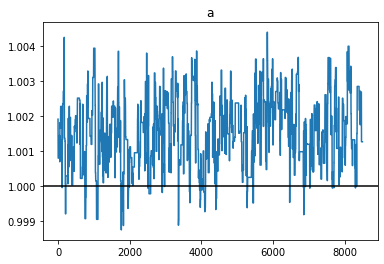

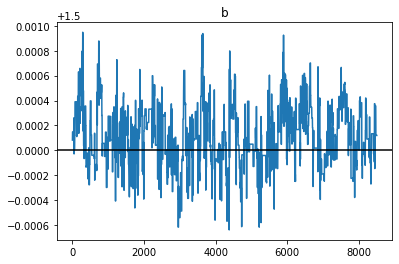

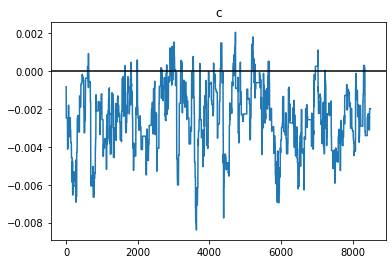

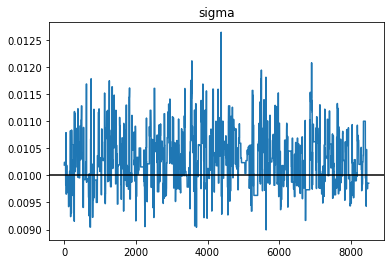

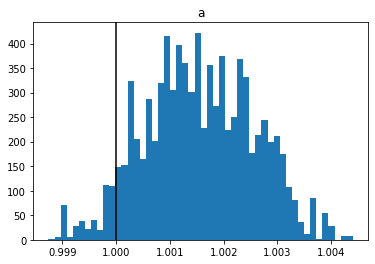

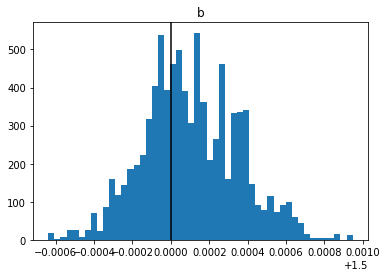

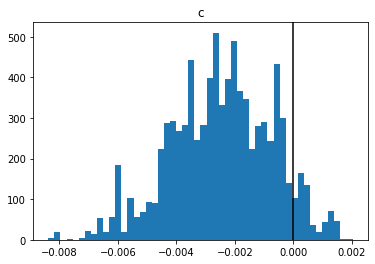

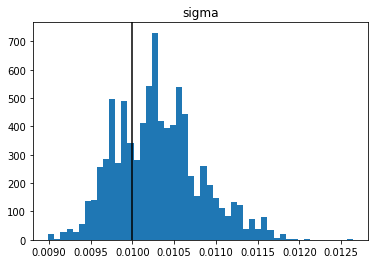

In [ ]:
param_true = [a_true, b_true, c_true, sigma_true]
param_names = ['a', 'b', 'c', 'sigma']
for i in range(len(param_names)):
    plt.figure()
    plt.plot(chain[:,i])
    plt.axhline(param_true[i], c='k')
    plt.title(param_names[i])

burnin = 1500
for i in range(len(param_names)):
    plt.figure()
    plt.plot(chain[burnin:,i])
    plt.axhline(param_true[i], c='k')
    plt.title(param_names[i])

for i in range(len(param_names)):
    plt.figure()
    plt.hist(chain[burnin:,i], bins=50);
    plt.axvline(param_true[i], c='k')
    plt.title(param_names[i])